In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc
from pyspark.sql.functions import *

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
from time import time
import numpy as np

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

In [2]:
import findspark
findspark.init()

In [3]:
# create a Spark session
spark = SparkSession.builder.appName("churn").getOrCreate()

In [4]:
spark

Load and Clean Dataset

In [9]:
path = r"C:\Users\user\Downloads\Sparkify\mini_sparkify_event_data.json"
music_churn_data = spark.read.json(path)

In [10]:
# See the frame schema
music_churn_data .printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



<AxesSubplot:>

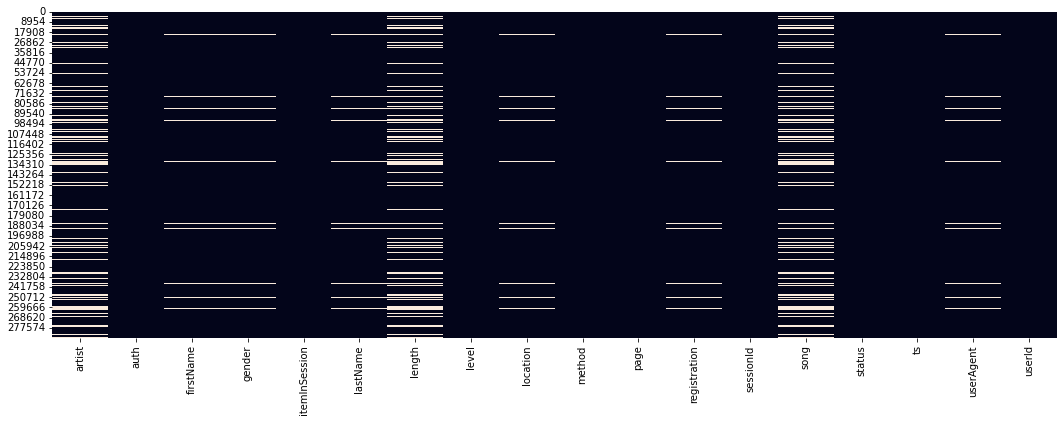

In [11]:
plt.figure(figsize=(18,6))
sns.heatmap(music_churn_data .toPandas().isnull(),cbar=False)

In [12]:
music_churn_data .filter(music_churn_data ['auth']=='Logged Out').show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [13]:
music_churn_data .select(music_churn_data ['userId']).filter(music_churn_data ['auth']=='Logged Out').show(10)

+------+
|userId|
+------+
|      |
|      |
|      |
|      |
|      |
|      |
|      |
|      |
|      |
|      |
+------+
only showing top 10 rows



In [14]:
music_churn_data .select(music_churn_data ['artist'],music_churn_data ['song'],music_churn_data ['length']).filter(music_churn_data ['page']!='NextSong').show(10)

+------+----+------+
|artist|song|length|
+------+----+------+
|  null|null|  null|
|  null|null|  null|
|  null|null|  null|
|  null|null|  null|
|  null|null|  null|
|  null|null|  null|
|  null|null|  null|
|  null|null|  null|
|  null|null|  null|
|  null|null|  null|
+------+----+------+
only showing top 10 rows



In [16]:
# Deleting missing userId and sessionid
music_churn_data  = music_churn_data.dropna(how = 'any', subset = ['userId','sessionId'])

In [17]:
music_churn_data = music_churn_data [music_churn_data .userId != ""]

<AxesSubplot:>

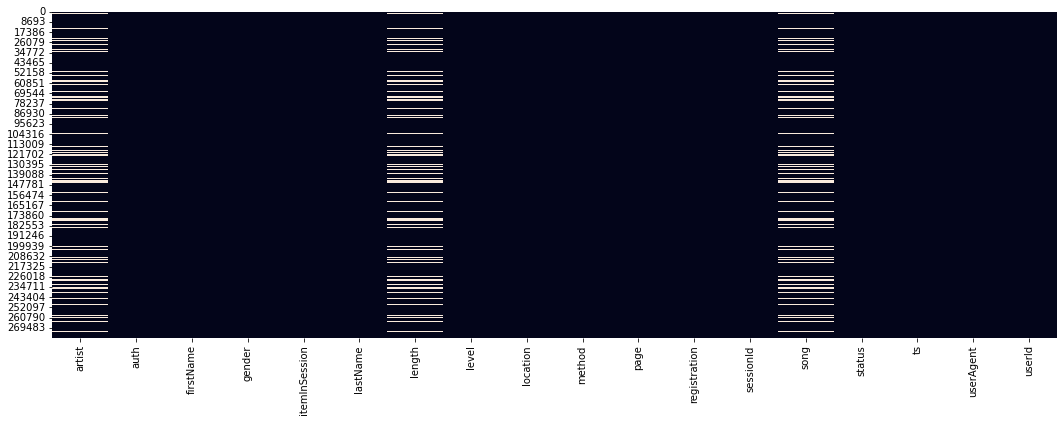

In [18]:
plt.figure(figsize=(18,6))
sns.heatmap(music_churn_data .toPandas().isnull(),cbar=False)

In [19]:
print("The no.of rows in the music churn data is {}".format(music_churn_data .count()))
print("The no of of col in the music churn data is {}".format(len(music_churn_data .columns)))

The no.of rows in the music churn data is 278154
The no of of col in the music churn data is 18



Exploratory Data Analysis

In [20]:
# Number of distinct users in the data set
music_churn_data .select("userId").dropDuplicates().count()

225

In [21]:
# Number of distinct sessions the music churn data
music_churn_data .select("sessionId").dropDuplicates().count()

2312

In [22]:
# User actions
music_churn_data.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



Define Churn

After performing some early analysis, make a column called Churn that will serve as the model's label. I advise leveraging the Withdrawal Confirmed occurrences, which occur for both free and premium customers, to identify the churn.

In [23]:
from pyspark.sql import Window
userWindow = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)

# labels churned users to be 1 and unchurned users to be 0 
music_churn_data= music_churn_data \
    .withColumn('Churn', when(col('page')=='Cancellation Confirmation', 1).otherwise(0)) \
    .withColumn('Churn', max('Churn').over(userWindow))

In [24]:
music_churn_data.head(1)

[Row(artist='OneRepublic', auth='Logged In', firstName='Bryanna', gender='F', itemInSession=0, lastName='Stone', length=224.67873, level='paid', location='Los Angeles-Long Beach-Anaheim, CA', method='PUT', page='NextSong', registration=1537440271000, sessionId=41, song='Secrets', status=200, ts=1539101664000, userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0', userId='100008', Churn=0)]

In [26]:
# convert 'registration' and 'ts' to date format
music_churn_data = music_churn_data \
    .withColumn('registrationTime', to_timestamp(music_churn_data ['registration']/1000)) \
    .withColumn('time', to_timestamp(music_churn_data ['ts']/1000)) 

In [27]:
music_churn_data.select(['userId', 'firstName','level', 'registrationTime' ,'Churn']).dropDuplicates(['userId']).show(10)

+------+---------+-----+-------------------+-----+
|userId|firstName|level|   registrationTime|Churn|
+------+---------+-----+-------------------+-----+
|   100|    Colin| paid|2018-09-26 18:17:35|    0|
|100004|    Emily| free|2018-06-09 17:04:02|    0|
|100005|    Cason| free|2018-07-26 14:15:26|    1|
|100006|    Leyla| free|2018-09-26 13:21:23|    1|
|100007|    Piper| paid|2018-08-06 03:26:59|    1|
|100008|  Bryanna| paid|2018-09-20 11:44:31|    0|
|100009|     Troy| free|2018-09-19 18:00:37|    1|
|100010| Darianna| free|2018-09-27 03:45:40|    0|
|100014|  Rodrigo| paid|2018-08-27 18:04:03|    1|
|100015|     Tina| free|2018-09-17 19:29:49|    1|
+------+---------+-----+-------------------+-----+
only showing top 10 rows



Explore Data

Churn users by genders

<AxesSubplot:title={'center':'Male users seems more likely to churn compared to female users.'}, xlabel='Churn', ylabel='count'>

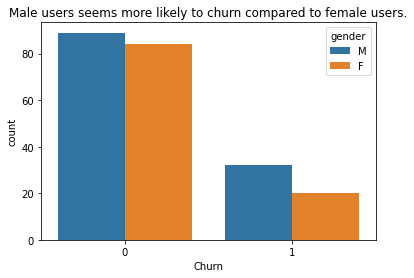

In [28]:
# Plotting a plots to represent gender distribution between regular and churn users
music_churn_data_pd= music_churn_data.drop_duplicates(['userId', 'gender']).groupby(['Churn', 'gender']).count().sort("Churn").toPandas()
plt.title('Male users seems more likely to churn compared to female users.')
sns.barplot(x = 'Churn', y = 'count', data = music_churn_data_pd, hue = 'gender')

Paid/Free customers churn

<AxesSubplot:title={'center':'Churn happens more in paid users.'}, xlabel='level', ylabel='count'>

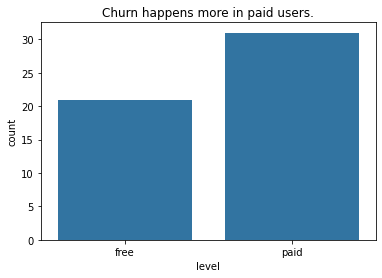

In [30]:
music_churn_data_level=music_churn_data.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
plt.title('Churn happens more in paid users.')
sns.barplot(data = music_churn_data_level, x = 'level', y = 'count', color = sns.color_palette()[0])

Number of songs played per session

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Churn users clearly played fewer songs per session.'}, xlabel='Churn', ylabel='avg_played_songs'>

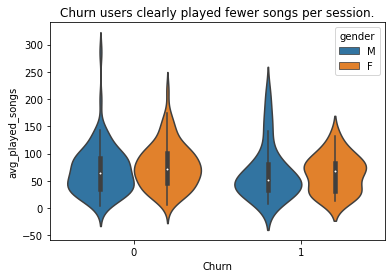

In [31]:
Avg_music_churn_songs  = music_churn_data.where('page == "NextSong"').groupby(['Churn', 'userId', 'sessionId', 'gender']).count()\
    .groupby(['Churn', 'userId', 'gender']).agg({'count': 'avg'})\
    .withColumnRenamed('avg(count)', 'avg_played_songs').toPandas()
plt.title('Churn users clearly played fewer songs per session.')
sns.violinplot('Churn', y = 'avg_played_songs', hue = 'gender', data =Avg_music_churn_songs )

Time since registration

In [32]:
music_churn_data_lt = music_churn_data.select('userId','registration','ts','Churn') \
    .withColumn('lifetime',(music_churn_data.ts-music_churn_data.registration)) \
    .groupBy('userId','Churn') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', 'Churn', (col('lifetime')/1000/3600/24).alias('lifetime')) \
    .toPandas()

Text(0.5, 1.0, 'Churn users use the services in shorter period of time.')

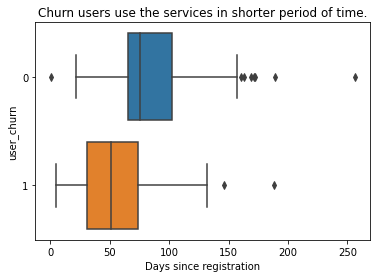

In [33]:
sns.boxplot(data=music_churn_data_lt, y='Churn', x='lifetime', orient='h')
plt.xlabel('Days since registration')
plt.ylabel('user_churn')
plt.title('Churn users use the services in shorter period of time.')

In [34]:
music_churn_data_friends = music_churn_data.where('page == "Add Friend"').groupby(['Churn', 'userId', 'gender']).count()\
    .groupby(['Churn', 'userId', 'gender']).agg({'count': 'avg'})\
    .withColumnRenamed('avg(count)', 'avg_friends').toPandas()

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Churn users seem have fewer friends in the services.'}, xlabel='Churn', ylabel='avg_friends'>

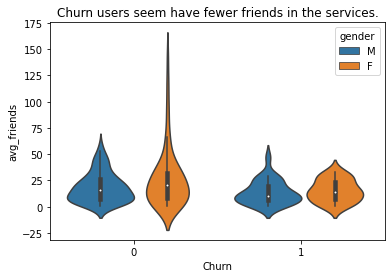

In [35]:
plt.title('Churn users seem have fewer friends in the services.')
sns.violinplot('Churn', y = 'avg_friends', hue = 'gender', data =music_churn_data_friends)

No handles with labels found to put in legend.


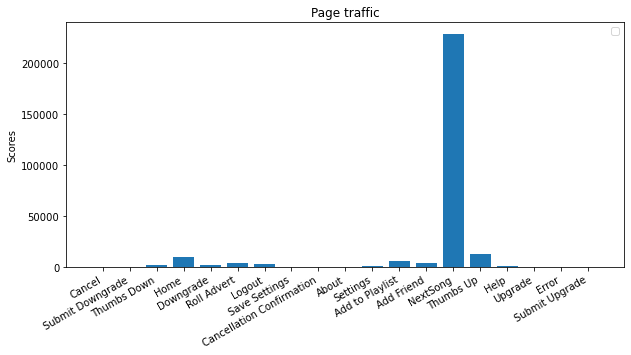

UsageError: Line magic function `%matplot` not found.


In [36]:
# plotting most often uses pages

pages_music_churn_data = music_churn_data.groupby('page').count().toPandas()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(pages_music_churn_data['page'], pages_music_churn_data['count'])
ax.set_ylabel('Scores')
ax.set_title('Page traffic')
ax.legend()
fig.autofmt_xdate()

plt.show()

%matplot plt

In [37]:
def extract_location_state(music_churn_data):
    """
        Splits the location column to extract just the letters of the state
    """
    split_col = split(music_churn_data['location'], ', ')
    music_churn_data = music_churn_data.withColumn("state", split_col.getItem(1))
    return music_churn_data

In [38]:
music_churn_data=extract_location_state(music_churn_data)

In [39]:
music_churn_data.toPandas().to_csv(r'C:\Users\user\spark1.csv')

Feature Engineering

In [40]:
# Total songs listened
music_churn_data_totalsngs = music_churn_data.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'total_songs_listened')
music_churn_data_totalsngs.show(5)

+------+--------------------+
|userId|total_songs_listened|
+------+--------------------+
|   125|                  11|
|    51|                2464|
|   124|                4825|
|     7|                 201|
|    54|                3437|
+------+--------------------+
only showing top 5 rows



In [41]:
# Number of thumbs up
music_churn_data_num_thumbsup =music_churn_data.select('userId', 'page').where(music_churn_data.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed\
('count', 'num_thumbs_up')
music_churn_data_num_thumbsup.show(5)

+------+-------------+
|userId|num_thumbs_up|
+------+-------------+
|    51|          100|
|   124|          171|
|     7|            7|
|    54|          163|
|    15|           81|
+------+-------------+
only showing top 5 rows



In [42]:
# Number of thumbs down
music_churn_data_num_thumbs_down = music_churn_data.select('userId', 'page').where(music_churn_data.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed\
('count', 'num_thumbs_down')
music_churn_data_num_thumbs_down.show(5)

+------+---------------+
|userId|num_thumbs_down|
+------+---------------+
|    51|             21|
|   124|             41|
|     7|              1|
|    15|             14|
|    54|             29|
+------+---------------+
only showing top 5 rows



In [43]:
# Total time since registration
music_churn_data_lifetime =music_churn_data.select('userId', 'registration', 'ts').withColumn('total_lifetime', (music_churn_data.ts - music_churn_data.registration))\
    .groupBy('userId').agg({'total_lifetime' : 'max'})\
    .withColumnRenamed('max(total_lifetime)', 'total_lifetime')\
    .select('userId', (col('total_lifetime')/1000/3600/24).alias('total_lifetime'))
music_churn_data_lifetime.show(5)

+------+------------------+
|userId|    total_lifetime|
+------+------------------+
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
|     7| 72.77818287037037|
|    54|110.75168981481481|
+------+------------------+
only showing top 5 rows



In [44]:
# Average songs played per session
music_data_song_played =music_churn_data.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby\
(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'avg_songs_played')
music_data_song_played.show(5)

+------+------------------+
|userId|  avg_songs_played|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



In [46]:
# Number of songs added to playlist
music_data_add_toplaylist =music_churn_data.select('userID','page').where(music_churn_data.page == 'Add to Playlist').groupBy('userID').count().withColumnRenamed\
('count', 'add_to_playlist')
music_data_add_toplaylist.show(5)

+------+---------------+
|userID|add_to_playlist|
+------+---------------+
|    51|             52|
|   124|            118|
|    15|             59|
|    54|             72|
|   132|             38|
+------+---------------+
only showing top 5 rows



In [47]:
# Total number of friends
music_data_total_friends = music_churn_data.select('userId', 'page').where(music_churn_data.page == 'Add Friend').groupBy('userId').count().withColumnRenamed\
('count', 'total_friends')
music_data_total_friends.show()

+------+-------------+
|userId|total_friends|
+------+-------------+
|    51|           28|
|   124|           74|
|     7|            1|
|    54|           33|
|    15|           31|
|   132|           41|
|   101|           29|
|   138|           41|
|    29|           47|
|    69|           12|
|    42|           52|
|    73|           11|
|    87|           27|
|   113|           32|
|    30|           25|
|   133|            1|
|    59|           16|
|   146|            9|
|     8|            5|
|    28|           20|
+------+-------------+
only showing top 20 rows



In [48]:
# churn label as target variable
music_churn =music_churn_data.select('userId', 'Churn').dropDuplicates()
music_churn.show(5)

+------+-----+
|userId|Churn|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
+------+-----+
only showing top 5 rows



In [49]:
def features_merge(music_churn_data1, music_churn_data2):
    music_churn_data2 = music_churn_data2.withColumnRenamed("userId", "userId_dup")
    music_churn_data= music_churn_data1.join(music_churn_data2, music_churn_data1.userId == music_churn_data2.userId_dup, "left").drop("userId_dup")
    return music_churn_data

In [51]:
music_features= [music_churn_data_totalsngs, music_churn_data_num_thumbsup, music_churn_data_num_thumbs_down, music_churn_data_lifetime, music_data_song_played, music_data_add_toplaylist, 
                 music_data_total_friends]

In [52]:
# setting the churn label for the model
music_trgt = music_churn_data.select('userId', col('Churn').alias('target')).dropDuplicates()
music_trgt.show(5)

+------+------+
|userId|target|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     0|
|100003|     1|
+------+------+
only showing top 5 rows



In [53]:
music_churn_data_final = music_trgt

for feature in music_features:
    music_churn_data_final = features_merge(music_churn_data_final, feature)

In [54]:
music_churn_data_final = music_churn_data_final.na.fill(0)
music_churn_data_final = music_churn_data_final.orderBy('userId', ascending=True)
music_churn_data_final.head(5)

[Row(userId='10', target=0, total_songs_listened=795, num_thumbs_up=37, num_thumbs_down=4, total_lifetime=51.76265046296297, avg_songs_played=112.16666666666667, add_to_playlist=9, total_friends=12),
 Row(userId='100', target=0, total_songs_listened=3214, num_thumbs_up=148, num_thumbs_down=27, total_lifetime=64.87377314814815, avg_songs_played=78.88235294117646, add_to_playlist=61, total_friends=49),
 Row(userId='100001', target=1, total_songs_listened=187, num_thumbs_up=8, num_thumbs_down=2, total_lifetime=44.80021990740741, avg_songs_played=33.25, add_to_playlist=3, total_friends=2),
 Row(userId='100002', target=0, total_songs_listened=218, num_thumbs_up=5, num_thumbs_down=0, total_lifetime=160.47207175925925, avg_songs_played=48.75, add_to_playlist=5, total_friends=1),
 Row(userId='100003', target=1, total_songs_listened=78, num_thumbs_up=3, num_thumbs_down=0, total_lifetime=22.748113425925926, avg_songs_played=25.5, add_to_playlist=2, total_friends=0)]

Modeling

Vectorize all features

In [58]:
music_churn_vectorize = VectorAssembler(inputCols=music_churn_data_final.columns[2:], outputCol='features_vector')
music_churn_data_final = music_churn_vectorize.transform(music_churn_data_final)

In [59]:
music_churn_data_final.head()

Row(userId='10', target=0, total_songs_listened=795, num_thumbs_up=37, num_thumbs_down=4, total_lifetime=51.76265046296297, avg_songs_played=112.16666666666667, add_to_playlist=9, total_friends=12, features_vector=DenseVector([795.0, 37.0, 4.0, 51.7627, 112.1667, 9.0, 12.0]))

Standardizing all features

In [61]:
music_scaler = StandardScaler(inputCol = 'features_vector', outputCol = "standard_features", withMean=True, withStd=True)
music_feature_standardize = music_scaler.fit(music_churn_data_final)
music_churn_data_final = music_feature_standardize.transform(music_churn_data_final)

In [62]:
music_churn_data_final.head()

Row(userId='10', target=0, total_songs_listened=795, num_thumbs_up=37, num_thumbs_down=4, total_lifetime=51.76265046296297, avg_songs_played=112.16666666666667, add_to_playlist=9, total_friends=12, features_vector=DenseVector([795.0, 37.0, 4.0, 51.7627, 112.1667, 9.0, 12.0]), standard_features=DenseVector([-0.3319, -0.2868, -0.5594, -0.7457, 0.9709, -0.6114, -0.3405]))

In [63]:
music_dataa = music_churn_data_final.select( music_churn_data_final.target.alias("label"), music_churn_data_final.standard_features.alias("features"))
music_dataa.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-0.3318762497700...|
|    0|[1.48756135378766...|
|    1|[-0.7891801203625...|
|    0|[-0.7658636401184...|
|    1|[-0.8711638734785...|
+-----+--------------------+
only showing top 5 rows



In [65]:
music_train, music_test = music_dataa.randomSplit([0.7, 0.3], seed=42)

In [66]:
music_train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   42|
|    0|  121|
+-----+-----+



In [67]:
music_test.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   10|
|    0|   52|
+-----+-----+



In [73]:
def evaluate_performance(model_result, model_name, start, end):
    music_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    print('{} performance metrics:'.format(model_name))
    print('Accuracy: {}'.format(music_evaluator.evaluate(model_result, {music_evaluator.metricName: "accuracy"})))
    print('F-1 Score:{}'.format(music_evaluator.evaluate(model_result, {music_evaluator.metricName: "f1"})))
    print('Total training time: {} seconds'.format(end - start))

In [76]:
numFolds = 3
logistic_reg = LogisticRegression(maxIter=10, labelCol='label', 
                            featuresCol='features')
evaluator = MulticlassClassificationEvaluator(labelCol='label')
pipeline = Pipeline(stages=[logistic_reg])
logistic_reg_paramGrid = (ParamGridBuilder()
                .addGrid(logistic_reg.regParam, [0.1, 0.01, 0.001])
                .build())
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=logistic_reg_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

In [78]:
music_start = time()
logistic_reg_model = crossval.fit(music_train)
music_end = time()
logistic_reg_model.avgMetrics

[0.7169662654047738, 0.7670120479221646, 0.7694595594092054]

In [79]:
logistic = logistic_reg_model.transform(music_test)

In [80]:
evaluate_performance(logistic, "Logistic Regression", music_start,music_end)

Logistic Regression performance metrics:
Accuracy: 0.8387096774193549
F-1 Score:0.8312707107594509
Total training time: 337.6557240486145 seconds


In [81]:
random_frst = RandomForestClassifier(seed = 42)

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')

rf_param_grid = ParamGridBuilder() \
    .addGrid(random_frst.numTrees, [10, 20]) \
    .addGrid(random_frst.maxDepth, [10, 20]) \
    .build()

random_frst_cv = CrossValidator(estimator = random_frst, estimatorParamMaps =rf_param_grid, evaluator = f1_evaluation, numFolds = 3)

In [82]:
music_start = time()
rf_cv_model =random_frst_cv.fit(music_train)
music_end = time()
rf_cv_model.avgMetrics

[0.8191072827200686,
 0.8191072827200686,
 0.8072321120789147,
 0.8072321120789147]

In [83]:
results_random_frst = rf_cv_model.transform(music_test)

In [85]:
evaluate_performance(results_random_frst, "Random Forest", music_start,music_end)

Random Forest performance metrics:
Accuracy: 0.7580645161290323
F-1 Score:0.7702498160054433
Total training time: 518.6222968101501 seconds
